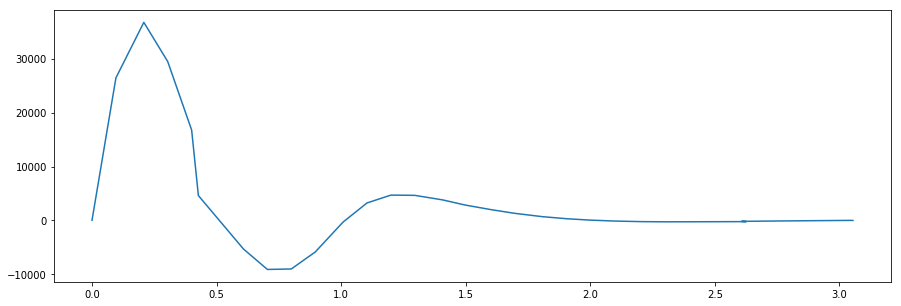

In [6]:
#! /usr/bin/env python
# -*- coding:utf-8 -*-
'''md
    [20210901]:
        将读取的数据以列表的形式存储起来，考虑存储为csv文件的形式
        通过如下命令可以直接将指定的话题以CSV的格式存储起来
        `rostopic echo -b wing_2021911518.bag -p /Impedance/wing/velocity/drive > topic_1.csv`
        - [使用rostopic echo将rosbag文件转换成csv](https://blog.csdn.net/cliukai/article/details/94554350)
        - [rostopic - ROS Wiki](http://wiki.ros.org/rostopic)
    [20210414]:
        yaml.FullLoader出现问题
        `pip install --ignore-installed PyYAML`
    [README]:
        参考roswiki上有关rosbag的API
'''
# %% import
from os import write
import rosbag
import rosmsg
import time
import yaml
import getpass
import csv
import numpy as np
import matplotlib.pyplot as plt
# msg
from copley.msg import ucr_msg
# tool
from tools_lib.debug_stream import DebugSteam
from tools_lib.make_directory import mk_dir

# %% class
class PlotBag(DebugSteam):
    def plot_topic(self, path_csv):
        bag_csv = open(path_csv,'r')
        try:
            data = np.loadtxt(bag_csv, dtype=float, delimiter=",", skiprows=1, usecols=(1,2))
            # [numpy读取csv文件](https://blog.csdn.net/u012413551/article/details/87890989)
            cols_01 = data[:,0]
            cols_02 = data[:,1]
            # self.debug_stream(cols_01, cols_02)
            plt.figure(0, figsize=(15,5))
            plt.plot(cols_01, cols_02)
            plt.show()
        finally:
            bag_csv.close()
    def spin(self):
        file_path_csv = "/home/{}/catkin_ws/csv/202191/1518/Impedance/".format(getpass.getuser())
        file_name = "drive_20218301323"
        path_csv = "{}{}.csv".format(file_path_csv, file_name)

        self.plot_topic(path_csv)

# %%
def main():
    plot_bag = PlotBag()
    plot_bag.spin()
if __name__ == '__main__':
    main()

In [1]:
#! /usr/bin/env python
# -*- coding:utf-8 -*-
'''md
    [20210902]:
        1. 该函数的前身是`rosbag_read.py`
        2. 之后就用这个函数来读取bag包中的数据并绘制简图
        3. 复杂的绘图使用csv_2_plot.py
    [20210901]:
        将读取的数据以列表的形式存储起来，考虑存储为csv文件的形式
        通过如下命令可以直接将指定的话题以CSV的格式存储起来
        `rostopic echo -b wing_2021911518.bag -p /Impedance/wing/velocity/drive > topic_1.csv`
        - [使用rostopic echo将rosbag文件转换成csv](https://blog.csdn.net/cliukai/article/details/94554350)
        - [rostopic - ROS Wiki](http://wiki.ros.org/rostopic)
    [20210414]:
        yaml.FullLoader出现问题
        `pip install --ignore-installed PyYAML`
    [README]:
        参考roswiki上有关rosbag的API
'''
# %% import
import rosbag
import rosmsg
import time
import yaml
import getpass
import csv
import numpy as np
import matplotlib.pyplot as plt
# msg
from copley.msg import ucr_msg
# tool
from tools_lib.debug_stream import DebugSteam
from tools_lib.make_directory import mk_dir

# %% class
class ReadBag(DebugSteam):
    def __init__(self):
            self.msg_header_seq = []
            self.secs_nsecs = []
            self.msg_velocity_wing_motor_l = []
            self.msg_velocity_wing_motor_r = []
    def bag_path(self):
        file_path_bag = "/home/{}/catkin_ws/bag/202192/138/feedback/Impedance/".format(getpass.getuser())
        file_path_csv = "/home/{}/catkin_ws/bag/202192/138/feedback/Impedance/".format(getpass.getuser())
        file_name = "wing_202192138"
        path_bag = "{}{}.bag".format(file_path_bag, file_name)
        path_csv = "{}{}.csv".format(file_path_csv, file_name)
        mk_dir(file_path_csv)
        return {'bag':path_bag, 'csv':path_csv}
    def topic2csv(self, header, path_csv, path_bag):
        '''
            path_bag
            path_csv: '/home/ubuntu/catkin_ws/csv/topic_02.csv'
            header: ['seq','secs','vel_l','vel_r']
            row: [msg.header.seq, 
                    secs_nsecs, 
                    msg.velocity.drive.motor_l, 
                    msg.velocity.drive.motor_r,]
        '''
        bag_info = rosbag.Bag(path_bag, mode='r')
        info_dict = yaml.load(bag_info._get_yaml_info(), Loader=yaml.FullLoader)
            # {'end': 1630480726.396359, 'compression': 'none', 'topics': [{'topic': 'Impedance/wing', 'type': 'copley/ucr_msg', 'frequency': 10.4162, 'messages': 85}], 'messages': 85, 'start': 1630480718.009544, 'version': 2.0, 'types': [{'type': 'copley/ucr_msg', 'md5': '697cf9df9ce516a16d261952c472d294'}], 'indexed': True, 'path': '/home/ubuntu/catkin_ws/bag/202191/1518/Impedance/wing_2021911518.bag', 'duration': 8.386815, 'size': 21026}
        bag_messages = bag_info.read_messages(topics=[info_dict['topics'][0]['topic']])
        bag_csv = open(path_csv,'w')
        try:
            writer = csv.writer(bag_csv)
            writer.writerow(header)
            for topic, msg, t in bag_messages:
                secs_nsecs = float("{}.{}".format(msg.header.stamp.secs, msg.header.stamp.nsecs)) - info_dict['start']
                row = [msg.header.seq, 
                            secs_nsecs, 
                            msg.velocity.wing.motor_l, 
                            msg.velocity.wing.motor_r,]
                writer.writerow(row)
                # 
                self.msg_header_seq.append(msg.header.seq)
                self.secs_nsecs.append(secs_nsecs)
                self.msg_velocity_wing_motor_l.append(msg.velocity.wing.motor_l)
                self.msg_velocity_wing_motor_r.append(msg.velocity.wing.motor_r)
        except rosbag.bag.ROSBagFormatException as error:
            error
        finally:
            bag_info.close()
            bag_csv.close()
    def topic2plot(self):
        msg_header_seq = np.array(self.msg_header_seq)
        secs_nsecs = np.array(self.secs_nsecs)
        msg_velocity_wing_motor_l = np.array(self.msg_velocity_wing_motor_l)
        msg_velocity_wing_motor_r = np.array(self.msg_velocity_wing_motor_r)
        coeff = 1.0
        plt.figure(0, figsize=(20*coeff, 6.18*coeff))
        plt.plot(np.arange(0,len(msg_header_seq),1), msg_velocity_wing_motor_l, 'b', linewidth=1)
        plt.show()
    def spin(self):
        path = self.bag_path()
        header = ['seq','secs','vel_l','vel_r']
        self.topic2csv(header, path['csv'], path['bag'])
        self.topic2plot()

# %%
def main():
    read_bag = ReadBag()
    read_bag.spin()
if __name__ == '__main__':
    main()

/home/ubuntu/catkin_ws/bag/202192/138/feedback/Impedance/ Exist


AttributeError: 'ReadBag' object has no attribute 'msg_velocity_wing_motor_l'